## Intro/ préparation

Ici, j'importe les bibliothèques de nécessaire et modifie les options pour rendre les graphe et tableau plus lisible Ensuite j'upload sur google colab les fichier csv



In [2]:
# Render our plots inline
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

In [24]:
# upload files from the local drive to the google colab
from google.colab import files
uploaded = files.upload()

Saving cities.csv to cities (1).csv
Saving providers.csv to providers (1).csv
Saving stations.csv to stations (1).csv
Saving ticket_data.csv to ticket_data (1).csv


In [3]:
# create data_frame for each files
df_cities=pd.read_csv('cities.csv')
df_providers=pd.read_csv('providers.csv')
df_stations=pd.read_csv('stations.csv')
df_ticket=pd.read_csv('ticket_data.csv')

### Affichage de la structure des dataframes

In [63]:
df_cities.head()

,id,local_name,unique_name,latitude,longitude,population
0,5159,"Padua, Veneto, Italia",padua,45.406435,11.876761,209678.0
1,76,"Barcelona, Cataluña, España",barcelona,41.385064,2.173404,1611822.0
2,81,"Basel, Basel-Stadt, Schweiz",basel,47.593437,7.619812,NaN
3,259,"Erlangen, Bayern, Deutschland",erlangen,49.589674,11.011961,105412.0
4,11979,"Balș, Olt, România",balș,44.353354,24.095672,NaN


In [ ]:
df_providers.head()

,id,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type
0,9,1,NaN,ouibus,Ouibus,True,True,True,False,bus
1,10,2,NaN,deinbus,Deinbus.de,False,False,False,False,bus
2,11,3,NaN,infobus,Infobus,False,False,False,False,bus
3,12,4,NaN,studentAgency,Student Agency,False,False,False,False,bus
4,13,5,NaN,flixbus,Flixbus,True,False,False,False,bus


In [ ]:
df_stations.head()

,id,unique_name,latitude,longitude
0,1,Aalen (Stuttgarter Straße),48.835296,10.092956
1,2,Aéroport Bordeaux-Mérignac,44.830226,-0.700883
2,3,Aéroport CDG,49.009900,2.559310
3,4,Aéroport de Berlin-Schönefeld,52.389446,13.520345
4,5,Aéroport de Dresden,51.123604,13.764737


In [ ]:
df_ticket.head()

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00:00,2017-10-13 20:10:00+00:00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00:00,2017-10-14 06:55:00+00:00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 21:24:00+00:00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 11:02:00+00:00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00:00,2017-10-14 19:32:00+00:00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542


## First Mission

minimal price for a ticket is  300  cents
maximal price for a ticket is  38550  cents
average price for a ticket is  4382.711061374178  cents


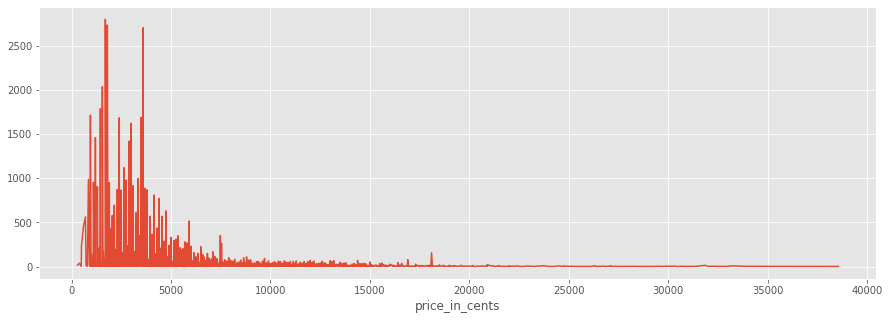

In [4]:
min_ticket_price = min(df_ticket['price_in_cents'])
max_ticket_price = max(df_ticket['price_in_cents'])
avg_ticket_price = df_ticket['price_in_cents'].mean()
#number of ticket by the ticket price
df_ticket.groupby('price_in_cents')['price_in_cents'].count().plot()
print('minimal price for a ticket is ', min_ticket_price ,' cents')
print('maximal price for a ticket is ', max_ticket_price ,' cents')
print('average price for a ticket is ', avg_ticket_price ,' cents')


je convertis les chaînes de caractère en datatime64 pour faire une simple soustraction et obtenir le temps de voyage 

minimal travel time is  0 days 00:20:00
maximal travel time is  20 days 12:51:00
average travel time is  0 days 07:04:37.247600043


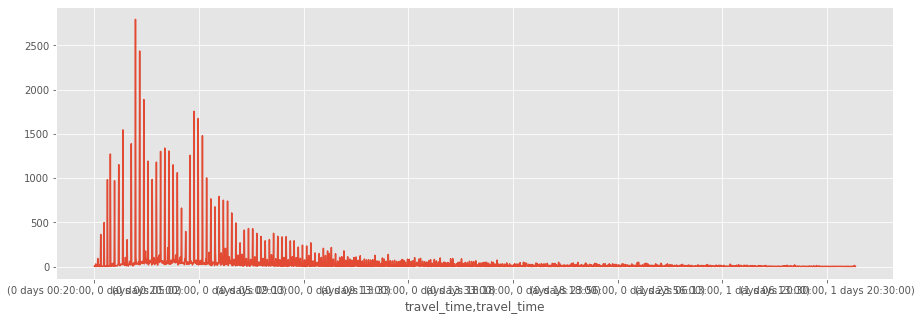

In [5]:
#convert string to datatime64
df_ticket['departure_ts'] = pd.to_datetime(df_ticket['departure_ts'])
df_ticket['arrival_ts'] = pd.to_datetime(df_ticket['arrival_ts'])
df_travelTime = pd.DataFrame()
df_travelTime['travel_time'] = df_ticket['arrival_ts']-df_ticket['departure_ts']
#number of ticket by the travel time
df_travelTime.groupby('travel_time')['travel_time'].value_counts().plot()
min_travelTime = min(df_travelTime['travel_time'])
max_travelTime = max(df_travelTime['travel_time'])
avg_travelTime = df_travelTime['travel_time'].mean()

print('minimal travel time is ', min_travelTime )
print('maximal travel time is ', max_travelTime )
print('average travel time is ', avg_travelTime )

## Second Mission

J'ai choisi de créer une fonction pour obtenir la distance à partir des coordonnées sphérique pour pouvoir l'utiliser ultérieurement.

In [6]:
import math
def distance(lat1, lon1, lat2, lon2):
    radius = 6371  # km
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

J'ai choisi de faire un boucle for pour la simplicité de mise en place, mais le temps de calcul est élevé. Mais elle permet d'avoir la distance pour tous les voyages.

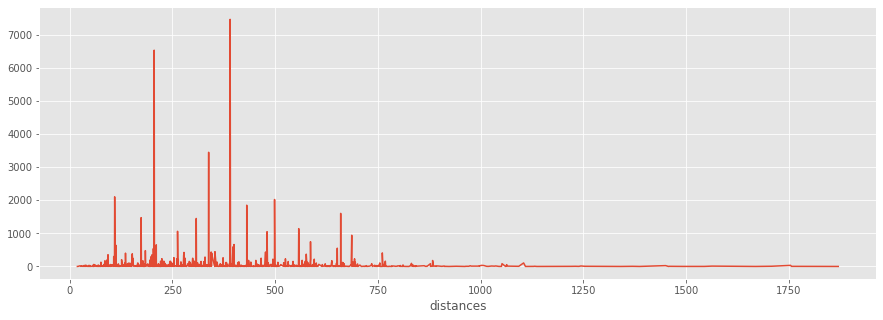

In [7]:
df_ticket_withDistance = df_ticket.copy()
distances = []
for index, row in df_ticket.iterrows():
  departure_city = row['o_city']
  arrival_city = row['d_city']
  departure_city_row = df_cities.loc[df_cities['id'] == departure_city]
  arrival_city_row = df_cities.loc[df_cities['id'] == arrival_city]
  lat1 = arrival_city_row['latitude'].values 
  lat2 = departure_city_row['latitude'].values
  lon1 = arrival_city_row['longitude'].values 
  lon2 = departure_city_row['longitude'].values
  dist = distance(lat1, lon1, lat2, lon2)
  distances.append(dist)
# fill the dataframe with the distance between cities
df_ticket_withDistance['distances'] = distances
#number of ticket by the travel distance
df_ticket_withDistance.groupby('distances')['distances'].count().plot()

Ici, on sépare les différents cas en fonction de la distance puis du mode de transport. Les cas des 'nan' n'est pas gérer pour question de simplicité.

In [11]:
df_ticket_over2000 = df_ticket_withDistance[df_ticket_withDistance['distances'] > 2000]

df_ticket_800_2000 = df_ticket_withDistance[df_ticket_withDistance['distances'] > 800]
df_ticket_800_2000 = df_ticket_800_2000[df_ticket_800_2000['distances'] <= 2000]

df_ticket_200_800 = df_ticket_withDistance[df_ticket_withDistance['distances'] > 200]
df_ticket_200_800 = df_ticket_200_800[df_ticket_200_800['distances'] <= 800]

df_ticket_0_200 = df_ticket_withDistance[df_ticket_withDistance['distances'] <= 200]

# merge ticket dataframe and company dataframe to get ticket price and transport type
df_ticket_0_200_company = df_ticket_0_200.merge(df_providers,how='inner' ,left_on='company' ,right_on='company_id')
df_ticket_200_800_company = df_ticket_200_800.merge(df_providers,how='inner' ,left_on='company' ,right_on='company_id')
df_ticket_800_2000_company = df_ticket_800_2000.merge(df_providers,how='inner' ,left_on='company' ,right_on='company_id')
df_ticket_over2000_company = df_ticket_over2000.merge(df_providers,how='inner' ,left_on='company' ,right_on='company_id')

# dataframe of ticket for traject under 200km
df_ticket_0_200_company_bus = df_ticket_0_200_company.loc[df_ticket_0_200_company['transport_type'] == 'bus']
df_travelTime_0_200_company_bus = df_ticket_0_200_company_bus['arrival_ts']-df_ticket_0_200_company_bus['departure_ts']
df_ticket_0_200_company_carpooling = df_ticket_0_200_company.loc[df_ticket_0_200_company['transport_type'] == 'carpooling']
df_travelTime_0_200_company_carpooling = df_ticket_0_200_company_carpooling['arrival_ts']-df_ticket_0_200_company_carpooling['departure_ts']
df_ticket_0_200_company_train = df_ticket_0_200_company.loc[df_ticket_0_200_company['transport_type'] == 'train']
df_travelTime_0_200_company_train = df_ticket_0_200_company_train['arrival_ts']-df_ticket_0_200_company_train['departure_ts']

# dataframe of ticket for traject between 200km and 800km
df_ticket_200_800_company_bus = df_ticket_200_800_company.loc[df_ticket_200_800_company['transport_type'] == 'bus']
df_travelTime_200_800_company_bus = df_ticket_200_800_company_bus['arrival_ts']-df_ticket_200_800_company_bus['departure_ts']
df_ticket_200_800_company_carpooling = df_ticket_200_800_company.loc[df_ticket_200_800_company['transport_type'] == 'carpooling']
df_travelTime_200_800_company_carpooling= df_ticket_200_800_company_carpooling['arrival_ts']-df_ticket_200_800_company_carpooling['departure_ts']
df_ticket_200_800_company_train = df_ticket_200_800_company.loc[df_ticket_200_800_company['transport_type'] == 'train']
df_travelTime_200_800_company_train = df_ticket_200_800_company_train['arrival_ts']-df_ticket_200_800_company_train['departure_ts']

# dataframe of ticket for traject between 800km and 2000km
df_ticket_800_2000_company_bus = df_ticket_800_2000_company.loc[df_ticket_800_2000_company['transport_type'] == 'bus']
df_travelTime_800_2000_company_bus = df_ticket_800_2000_company_bus['arrival_ts']-df_ticket_800_2000_company_bus['departure_ts']
df_ticket_800_2000_company_carpooling = df_ticket_800_2000_company.loc[df_ticket_800_2000_company['transport_type'] == 'carpooling']
df_travelTime_800_2000_company_carpooling = df_ticket_800_2000_company_carpooling['arrival_ts']-df_ticket_800_2000_company_carpooling['departure_ts']
df_ticket_800_2000_company_train = df_ticket_800_2000_company.loc[df_ticket_800_2000_company['transport_type'] == 'train']
df_travelTime_800_2000_company_train = df_ticket_800_2000_company_train['arrival_ts']-df_ticket_800_2000_company_train['departure_ts']

# dataframe of ticket for traject over 2000km 
df_ticket_over2000_company_bus = df_ticket_over2000_company.loc[df_ticket_over2000_company['transport_type'] == 'bus']
df_travelTime_over2000_company_bus = df_ticket_over2000_company_bus['arrival_ts']-df_ticket_over2000_company_bus['departure_ts']
df_ticket_over2000_company_carpooling = df_ticket_over2000_company.loc[df_ticket_over2000_company['transport_type'] == 'carpooling']
df_travelTime_over2000_company_carpooling = df_ticket_over2000_company_carpooling['arrival_ts']-df_ticket_over2000_company_carpooling['departure_ts']
df_ticket_over2000_company_train = df_ticket_over2000_company.loc[df_ticket_over2000_company['transport_type'] == 'train']
df_travelTime_over2000_company_train = df_ticket_over2000_company_train['arrival_ts']-df_ticket_over2000_company_train['departure_ts']


In [12]:
# print ticket price for traject under 200km
print('average price for a traject under 200km in bus ',df_ticket_0_200_company_bus['price_in_cents'].mean(),' in cents with a average travel time of : ',df_travelTime_0_200_company_bus.mean())
print('average price for a traject under 200km in carpooling ',df_ticket_0_200_company_carpooling['price_in_cents'].mean(),' in cents with a average travel time of : ',df_travelTime_0_200_company_carpooling.mean())
print('average price for a traject under 200km in train ',df_ticket_0_200_company_train['price_in_cents'].mean(),' in cents  with a average travel time of : ',df_travelTime_0_200_company_train.mean())


average price for a traject under 200km in bus  2093.8805970149256  in cents with a average travel time of :  0 days 10:05:32.238805970
average price for a traject under 200km in carpooling  1990.0  in cents with a average travel time of :  0 days 14:15:00
average price for a traject under 200km in train  nan  in cents  with a average travel time of :  NaT


In [13]:
# print ticket price for traject between 200km and 800km
print('average price for a traject between 200km and 800km in bus ',df_ticket_200_800_company_bus['price_in_cents'].mean(),' in cents with a average travel time of : ',df_travelTime_200_800_company_bus.mean())
print('average price for a traject between 200km and 800km in carpooling ',df_ticket_200_800_company_carpooling['price_in_cents'].mean(),' in cents with a average travel time of : ',df_travelTime_200_800_company_carpooling.mean())
print('average price for a traject between 200km and 800km in train ',df_ticket_200_800_company_train['price_in_cents'].mean(),' in cents with a average travel time of : ',df_travelTime_200_800_company_train.mean())


average price for a traject between 200km and 800km in bus  3273.347277023231  in cents with a average travel time of :  0 days 13:59:11.947258864
average price for a traject between 200km and 800km in carpooling  4338.5  in cents with a average travel time of :  0 days 10:36:15
average price for a traject between 200km and 800km in train  3265.5555555555557  in cents with a average travel time of :  0 days 12:42:13.333333333


In [14]:
# print ticket price for traject between 800km and 2000km
print('average price for a traject between 800km and 2000km in bus ',df_ticket_800_2000_company_bus['price_in_cents'].mean(),' in cents with a average travel time of : ',df_travelTime_800_2000_company_bus.mean())
print('average price for a traject between 800km and 2000km in carpooling ',df_ticket_800_2000_company_carpooling['price_in_cents'].mean(),' in cents with a average travel time of : ',df_travelTime_800_2000_company_carpooling.mean())
print('average price for a traject between 800km and 2000km in train ',df_ticket_800_2000_company_train['price_in_cents'].mean(),' in cents with a average travel time of :  ',df_travelTime_800_2000_company_train.mean())


average price for a traject between 800km and 2000km in bus  6112.710280373832  in cents with a average travel time of :  1 days 00:25:07.009345794
average price for a traject between 800km and 2000km in carpooling  nan  in cents with a average travel time of :  NaT
average price for a traject between 800km and 2000km in train  nan  in cents with a average travel time of :   NaT


In [15]:
# print ticket price for traject over 2000km 
print('average price for a traject over 2000km in bus ',df_ticket_over2000_company_bus['price_in_cents'].mean(),' in cents with a average travel time of : ',df_travelTime_over2000_company_bus.mean())
print('average price for a traject over 2000km in carpooling ',df_ticket_over2000_company_carpooling['price_in_cents'].mean(),' in cents with a average travel time of : ',df_travelTime_over2000_company_carpooling.mean())
print('average price for a traject over 2000km in train ',df_ticket_over2000_company_train['price_in_cents'].mean(),' in cents with a average travel time of :  ',df_travelTime_over2000_company_train.mean())


average price for a traject over 2000km in bus  nan  in cents with a average travel time of :  NaT
average price for a traject over 2000km in carpooling  nan  in cents with a average travel time of :  NaT
average price for a traject over 2000km in train  nan  in cents with a average travel time of :   NaT


## Bonus Mission

Ici, j'ai voulu permettre de pouvoir choisir la ville de départ et la ville d'arriver et afficher le temps minimal de trajet ainsi que le voyage le moins coûteux.
Pour cela, j'ai utilisé les mêmes principes que précédemment pour trier et faire ressortir les éléments désirés.

In [16]:
import sys
# enter a departure city and check if it's in the database
departure = input("Enter your departure city: ")  
departure_city_row = df_cities.loc[df_cities['unique_name'] == departure]
if departure_city_row.empty == True:
  sys.exit('there is no city with that name un the database')
# enter an arrival city and check if it's in the database
destination = input("Enter your destination city: ") 
arrival_city_row = df_cities.loc[df_cities['unique_name'] == destination]
if arrival_city_row.empty == True:
  sys.exit('there is no city with that name un the database')

# get distance between those cities
dist = distance(departure_city_row['latitude'].values[0], departure_city_row['longitude'].values[0], arrival_city_row['latitude'].values[0], arrival_city_row['longitude'].values[0])
print('distance between cities: ',dist)

departure_id = departure_city_row['id'].values[0]
arrival_id = arrival_city_row['id'].values[0]
df_departure = df_ticket.loc[df_ticket['o_city'] == departure_id]
df_departure_arrival = df_departure[df_departure['d_city'] == arrival_id]

# get the lowest travel time
min_time = min(df_departure_arrival['arrival_ts']-df_departure_arrival['departure_ts'])
print('mininal travel time: ',min_time)

# get lowest price
min_price = min(df_departure_arrival['price_in_cents'])
print('minimal price: ',min_price)
df_departure_arrival[df_departure_arrival['price_in_cents'] == min_price].head()

Enter your departure city: paris
Enter your destination city: lyon
distance between cities:  390.6282633081959
mininal travel time:  0 days 03:00:00
minimal price:  1550


,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city
45195,6840220,8385,NaN,NaN,2017-10-13 00:00:00+00:00,2017-10-13 05:00:00+00:00,1550,2017-10-12 13:31:25.443+00,NaN,NaN,628,485
46096,6841121,8385,NaN,NaN,2017-10-13 00:00:00+00:00,2017-10-13 05:00:00+00:00,1550,2017-10-12 15:39:14.323+00,NaN,NaN,628,485
46222,6841247,8385,NaN,NaN,2017-10-13 00:00:00+00:00,2017-10-13 05:00:00+00:00,1550,2017-10-12 15:41:10.157+00,NaN,NaN,628,485
